### AIM: Extract Time-Frequency object from EEG data and store in Numpy array for each participant's first session

Numpy array shape: [EC/EO, n_epochs, n_channels, n_freqs, n_times]

In [2]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet, tfr_multitaper

%matplotlib inline

In [3]:
# prevent extensive logging
mne.set_log_level('WARNING')

In [4]:
# set folder containing participants data as working directory
participants_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data"
os.chdir(participants_dir)
os.getcwd()

'D:\\Documents\\RU\\Master_Neurobiology\\Internship_jaar_2\\Project\\TD-BRAIN\\TDBRAIN_participants_V2_data'

In [5]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }


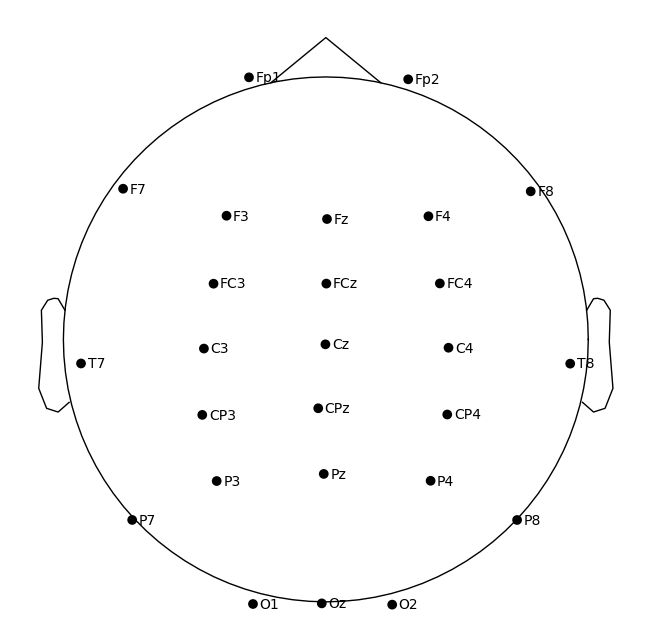

In [6]:
## Set montage and plot electrodes (Copied from Anne van Duijvenbode)

montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')
mne.viz.plot_montage(montage = montage, scale_factor=10, show_names=True, show=True, sphere='eeglab')

montage.save('montage_eeg.fif', overwrite = True)

In [7]:
# Create info object for MNE
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG, 5 EOG, 1 ECG, 1 EMG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>


# Time-frequency analysis

First for singular participant to determine workflow:

In [8]:
# load data and create epochs
eeg_data_path = 'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\sub-88078657\ses-1\eeg\sub-88078657_ses-1_task-restEC_eeg.csv'
eeg_data = pd.read_csv(eeg_data_path, sep=',')
eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
raw.notch_filter(50)
raw.filter(0.5, 100)
        
epochs = mne.make_fixed_length_epochs(raw, duration = 10, overlap = 0, baseline=) # overlap 0?
print(epochs)

<Epochs |  12 events (good & bad), 0 – 9.998 s, baseline off, ~40 kB, data not loaded,
 '1': 12>


### Morlet wave convolution

In [9]:
# define frequencies of interest (log-spaced) (just random for now)
freqs = np.arange(1, 91, 1, dtype=int) 
print(f'{freqs = }')
n_cycles = freqs / 2.0 # different number of cycles per frequency

epochsTFR = tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

power, itc= tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    average=True,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

freqs = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])


In [10]:
print(epochsTFR) # TFR for each epoch seperate
print(power) # TFR averaged over all epochs

<EpochsTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~1.05 GB>
<AverageTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], nave : 12, channels : 26, ~89.3 MB>


### Multitaper method

In [11]:
# define frequencies of interest (log-spaced) (just random for now)
freqs = np.arange(1, 91, 1, dtype=int) 
print(f'{freqs = }')
n_cycles = freqs / 2.0 # different number of cycles per frequency

epochsTFR_mt = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=False,
    average=False,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

power_mt, itc_mt= tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=True,
    average=True,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

freqs = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])


In [12]:
print(epochsTFR_mt) # TFR for each epoch seperate
print(power_mt) # TFR averaged over all epochs

<EpochsTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~1.05 GB>
<AverageTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], nave : 12, channels : 26, ~89.3 MB>


### Comparing Morlet vs Multitaper

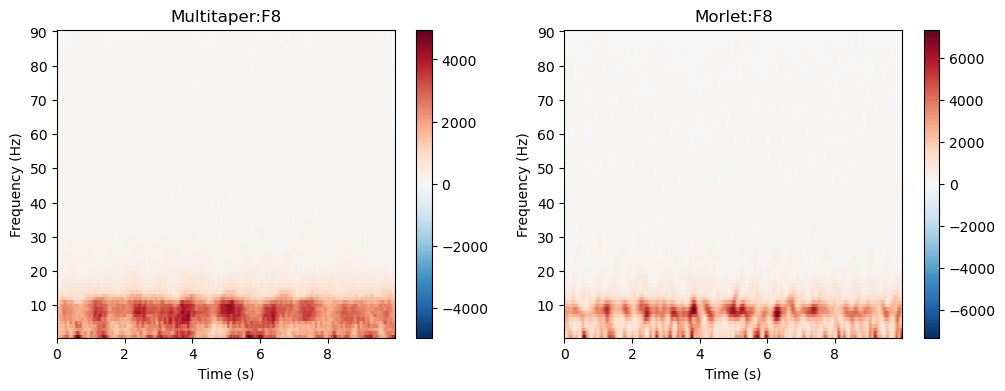

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

power_mt.plot([6], axes=ax1, show=False)
power.plot([6], axes=ax2, show=False)
ax1.set_title(f'Multitaper:{ch_names[6]}')
ax2.set_title(f'Morlet:{ch_names[6]}')
plt.show()

Text(0.5, 0.98, 'Morlet')

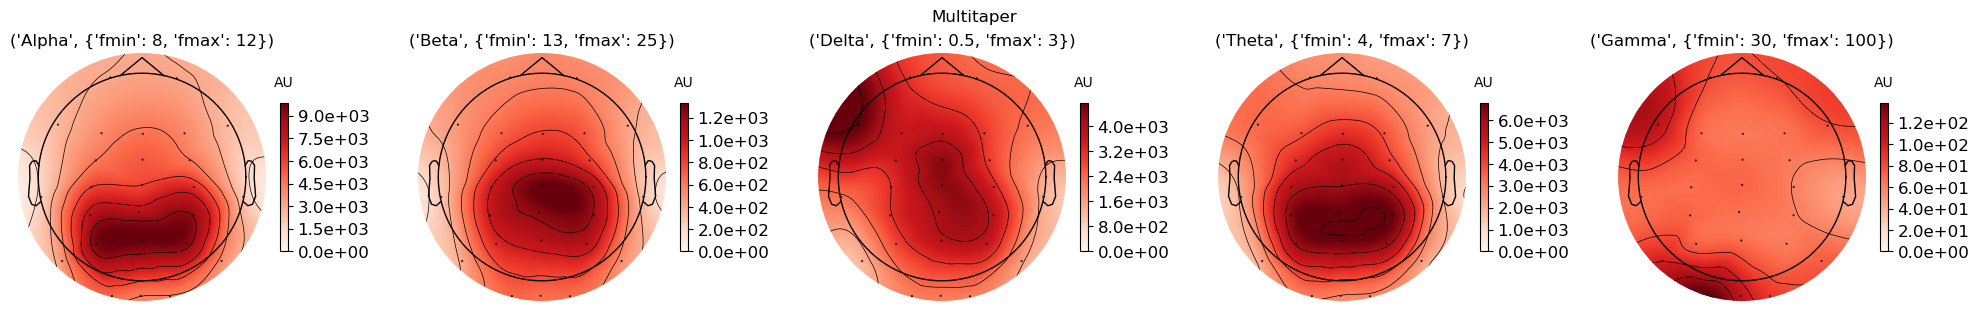

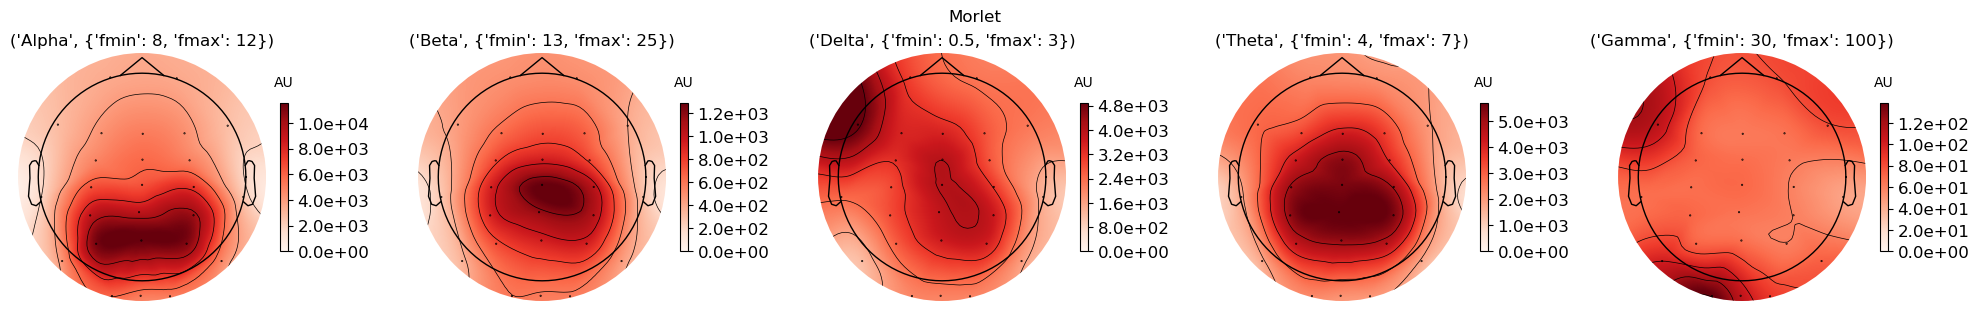

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(20, 3), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=1, tmax=2, show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25), Delta=dict(fmin=0.5, fmax=3), Theta=dict(fmin=4, fmax=7), Gamma=dict(fmin=30, fmax=100))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power_mt.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title((title, fmin_fmax))
fig.suptitle('Multitaper')

fig, axes = plt.subplots(1, 5, figsize=(20, 3), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=1, tmax=2, show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25), Delta=dict(fmin=0.5, fmax=3), Theta=dict(fmin=4, fmax=7), Gamma=dict(fmin=30, fmax=100))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title((title, fmin_fmax))
fig.suptitle('Morlet')


### Now, use the workflow for a single participant to create loop for all participants 

In [15]:
# define frequencies of interest
freqs = np.arange(1, 91, 1, dtype=int) 
print(f'{freqs = }')
n_cycles = freqs / 2.0 # different number of cycles per frequency

epochsTFR_mt = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=False,
    average=False,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

power_mt, itc_mt = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=True,
    average=True,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

freqs = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])


In [16]:
print(epochsTFR_mt) # TFR for each epoch seperate
print(power_mt) # TFR averaged over all epochs

<EpochsTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~1.05 GB>
<AverageTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], nave : 12, channels : 26, ~89.3 MB>


In [17]:
print(power_mt.data.shape) # shape (n_channels, n_freqs, n_times)
print(epochsTFR_mt.data.shape) # shape (n_epochs, n_channels, n_freqs, n_times)

(26, 90, 5000)
(12, 26, 90, 5000)


In [18]:
# try storing the MNE TFR object in numpy arrays
a = np.array(power_mt) # storing as object
b = np.array(power_mt)
c = np.append(a, b)
print(c.shape)
c[0].info # data is correctly stored and retrieved from object in numpy array

(2,)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 26
 projs: []
 sfreq: 500.0 Hz
>

In [19]:
# try storing the MNE TFR object in multidimensional numpy array
a = np.array(epochsTFR_mt)
b = np.expand_dims(a, axis=0)
b.shape


(1, 12, 26, 90, 5000)

In [20]:
a = np.array(power_mt)
b = np.expand_dims(a, axis=0)
print(a.shape)
print(b.shape)

()
(1,)


In [21]:
# try appending two multidimensional numpy arrays containing EpochsTFR data and check size
a = np.array([epochsTFR_mt])
b = np.array([epochsTFR_mt])
c = np.append(a, b, axis=0)
print(c.shape)
print(c.nbytes)

extracted_epochsTFR = c[0]
print(extracted_epochsTFR.nbytes)
print(extracted_epochsTFR.shape)

np.save('test_array.npy', c) # 2+ GB!!
print('.npy file is 2+ GB. If storing for all 1350 participants, I would need 2.7+ TB of storage')

(2, 12, 26, 90, 5000)
2246400000
1123200000
(12, 26, 90, 5000)
.npy file is 2+ GB. If storing for all 1350 participants, I would need 2.7+ TB of storage


In [22]:
# try appending two multidimensional numpy arrays containing AverageTFR data and check size
a = np.array([power_mt])
b = np.array([power_mt])
c = np.append(a, b, axis=0)
print(c.shape)
print(c.nbytes)

extracted_power = c[0]
print(extracted_power.data.nbytes)
print(extracted_power.data.shape)

np.save('test_array.npy', c) # 90 MB
print('.npy file is 90 MB. More managable, but data is averaged over epochs, and still 121.5 GB of storage needed for all participants')

(2,)
16
93600000
(26, 90, 5000)
.npy file is 90 MB. More managable, but data is averaged over epochs, and still 121.5 GB of storage needed for all participants


### Checking effect of 'decimate' parameter on TFR quality, to try to reduce file size

First checking for TFR calculated using the multitaper method

In [23]:
# define frequencies of interest
freqs = np.arange(1, 91, 1, dtype=int) 
print(f'{freqs = }')
n_cycles = freqs / 2.0 # different number of cycles per frequency

freqs = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])


In [24]:
# Create TFR objects with different values of 'decimate'
decim_params = [1, 2, 3, 4, 6, 8, 10, 12]
TFR_objects = {}

for decim_param in decim_params:
    TFR_object = tfr_multitaper(
        epochs,
        freqs=freqs,
        n_cycles=n_cycles,
        time_bandwidth=4, # just random for now
        use_fft=True,
        return_itc=False,
        average=False,
        decim=decim_param, # decim reduces sampling rate of the tf decomposition by the defined factor
        n_jobs=-1)
    TFR_objects[f'{decim_param = }'] = TFR_object
    
print(TFR_objects)

{'decim_param = 1': <EpochsTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~1.05 GB>, 'decim_param = 2': <EpochsTFR | time : [0.000000, 9.996000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~535.6 MB>, 'decim_param = 3': <EpochsTFR | time : [0.000000, 9.996000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~357.2 MB>, 'decim_param = 4': <EpochsTFR | time : [0.000000, 9.992000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~267.8 MB>, 'decim_param = 6': <EpochsTFR | time : [0.000000, 9.996000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~178.7 MB>, 'decim_param = 8': <EpochsTFR | time : [0.000000, 9.984000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~133.9 MB>, 'decim_param = 10': <EpochsTFR | time : [0.000000, 9.980000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~107.2 MB>, 'decim_param = 12': <EpochsTFR | time : [0.000000, 9.984000], freq : [1.000000, 90

In [25]:
# extract estimated file size
file_sizes = []
for key in TFR_objects:
    file_size = str(TFR_objects[key]).split(',')[6].replace(' ', '').replace('>', '')
    file_sizes.append(file_size)
print(file_sizes)

['~1.05GB', '~535.6MB', '~357.2MB', '~267.8MB', '~178.7MB', '~133.9MB', '~107.2MB', '~89.4MB']


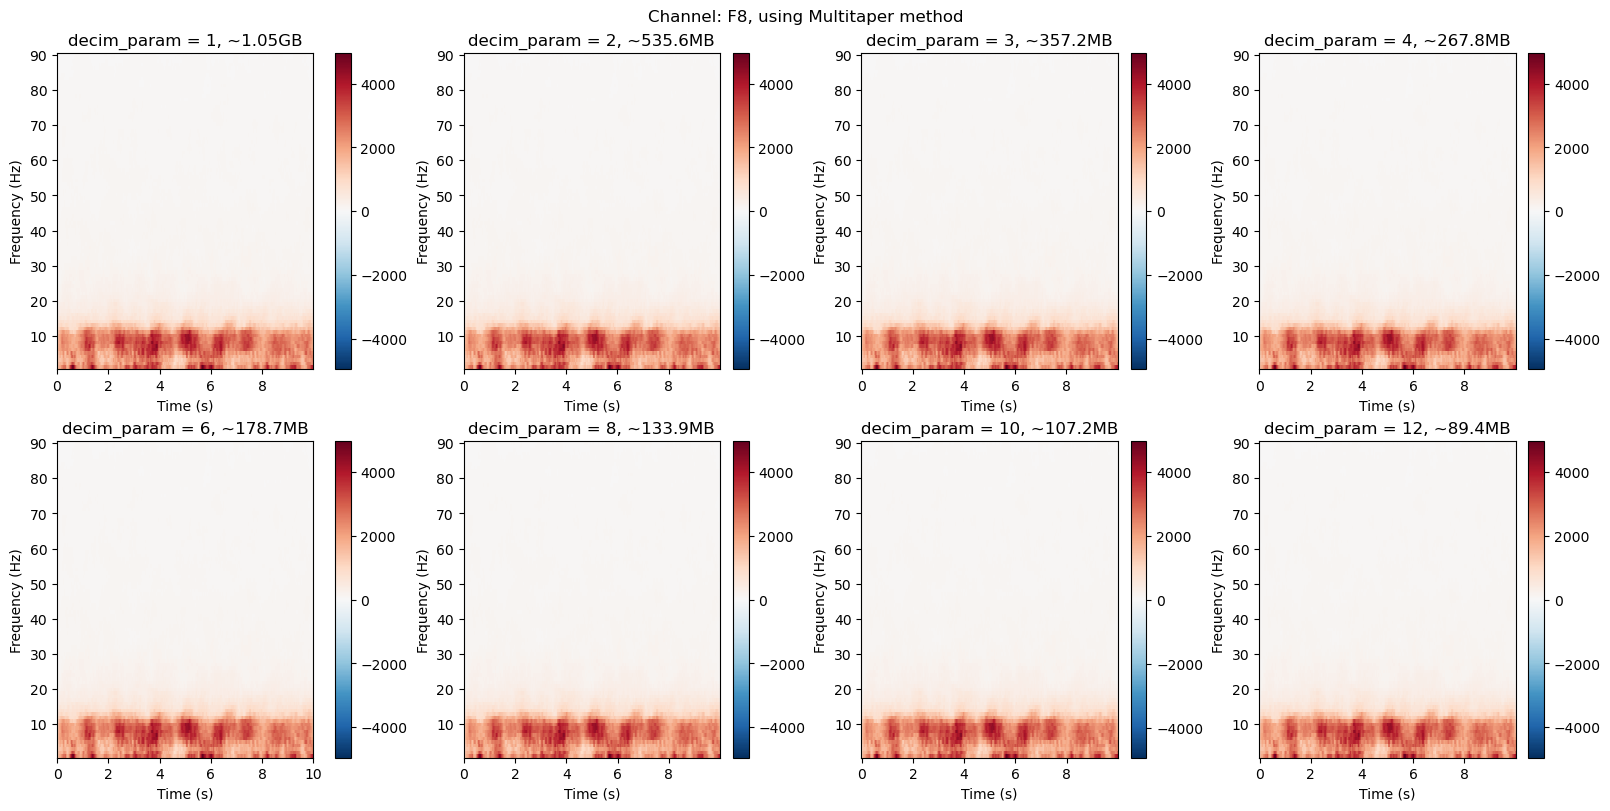

In [26]:
# plot all TFR_objects to visualize effect of 'decimate' parameter
fig, axes = plt.subplots(2, 4, figsize=(16, 8), layout='constrained')

for ax, (decim_param, TFR_object), file_size in zip(axes.ravel(), TFR_objects.items(), file_sizes):
    TFR_object.average().plot([6], axes=ax, show=False) # Have to average over epochs and select only 1 channel, in order to plot
    ax.set_title(f'{decim_param}, {file_size}')
fig.suptitle(f'Channel: {ch_names[6]}, using Multitaper method')
plt.show()
    

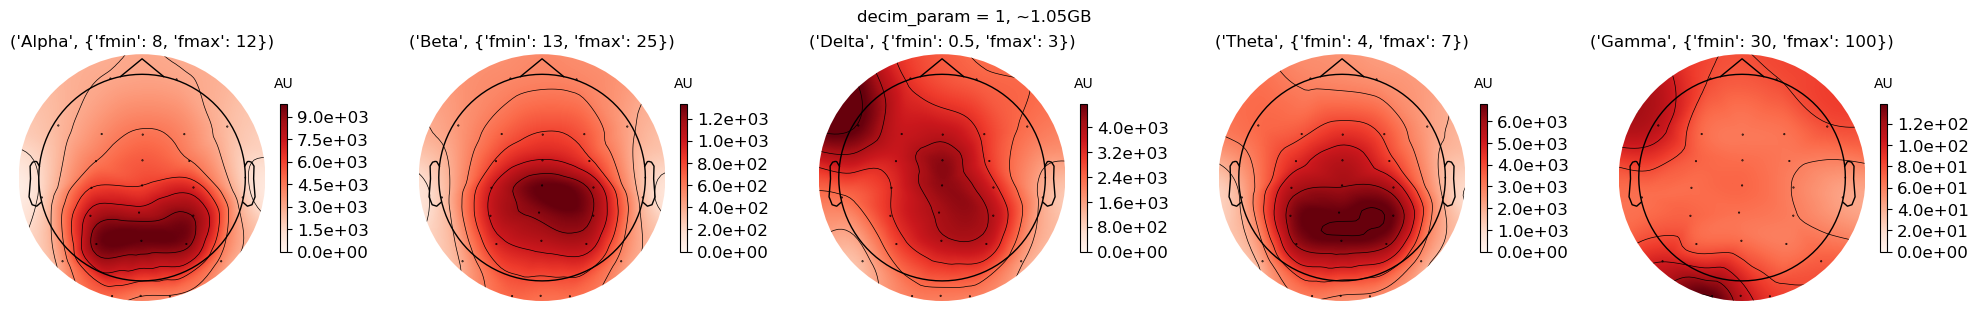

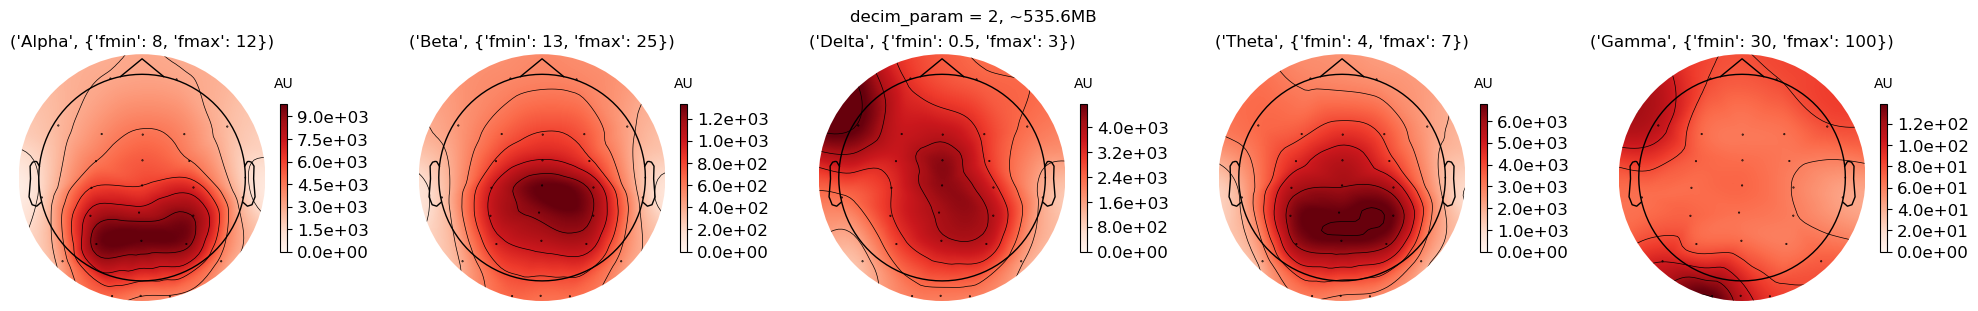

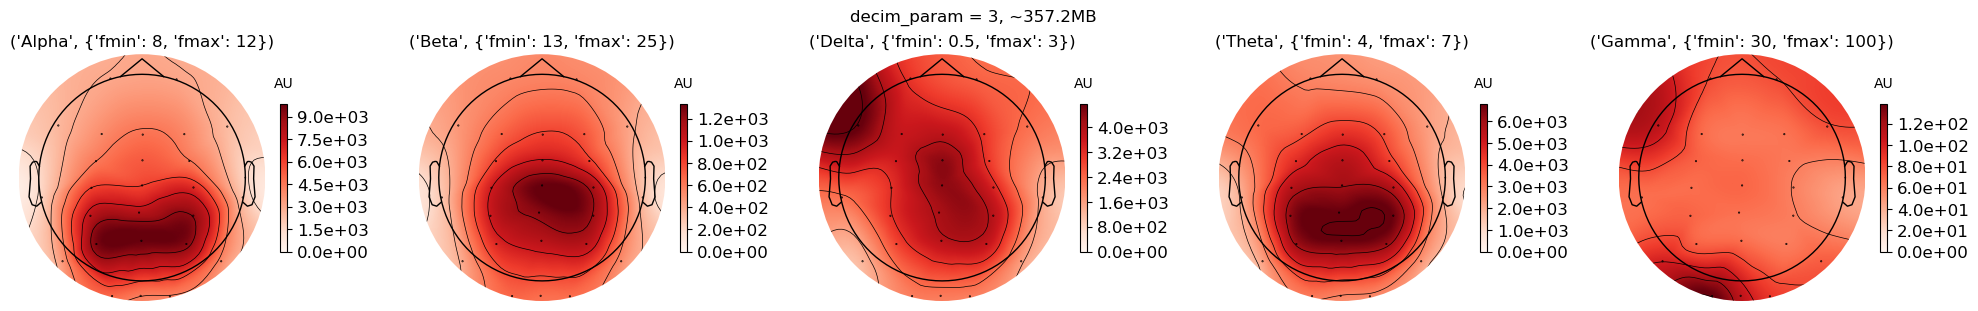

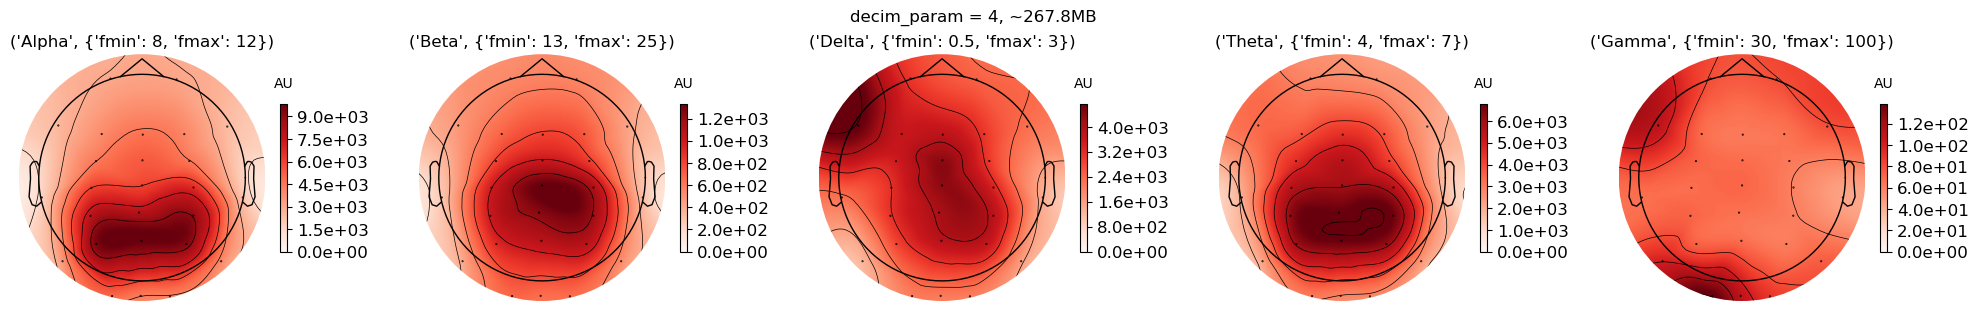

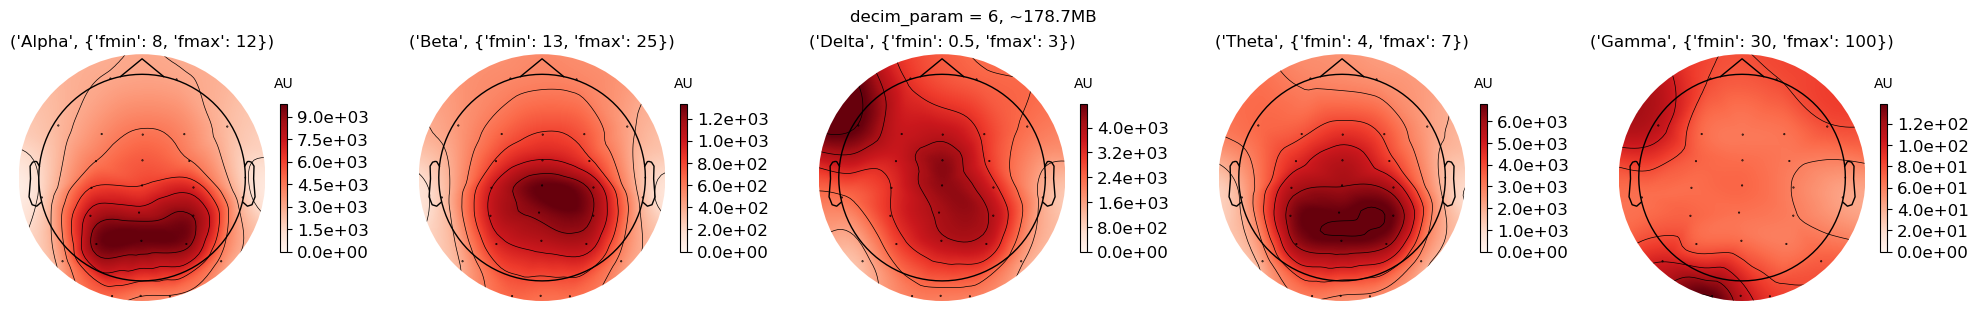

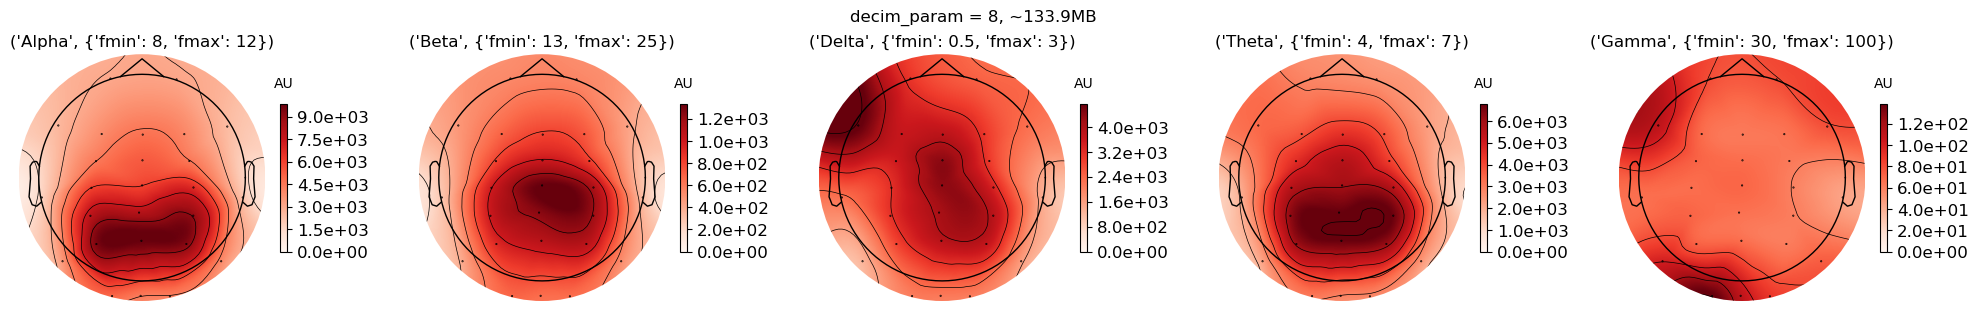

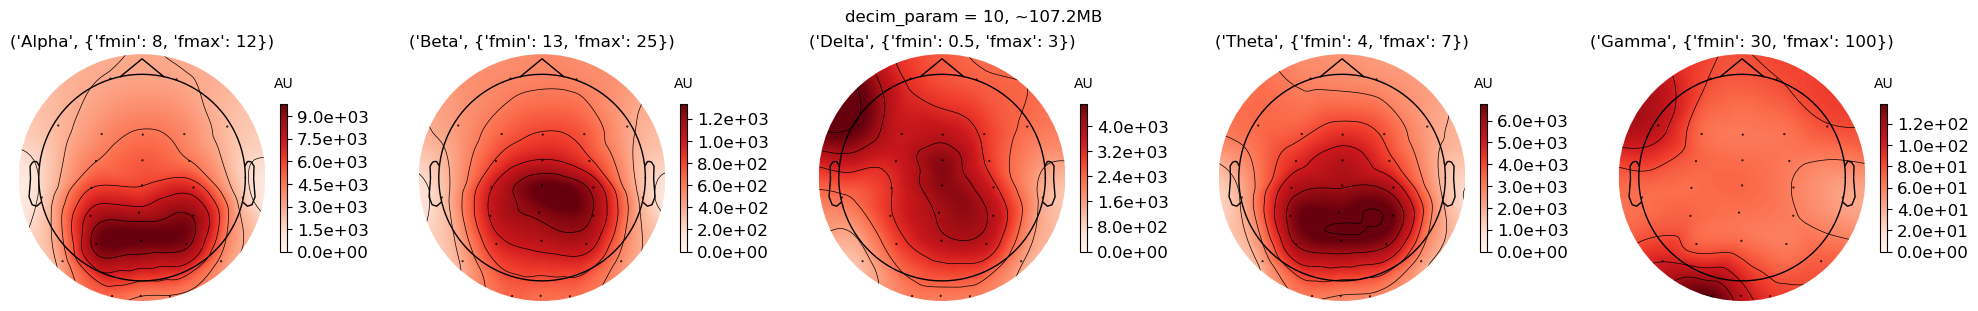

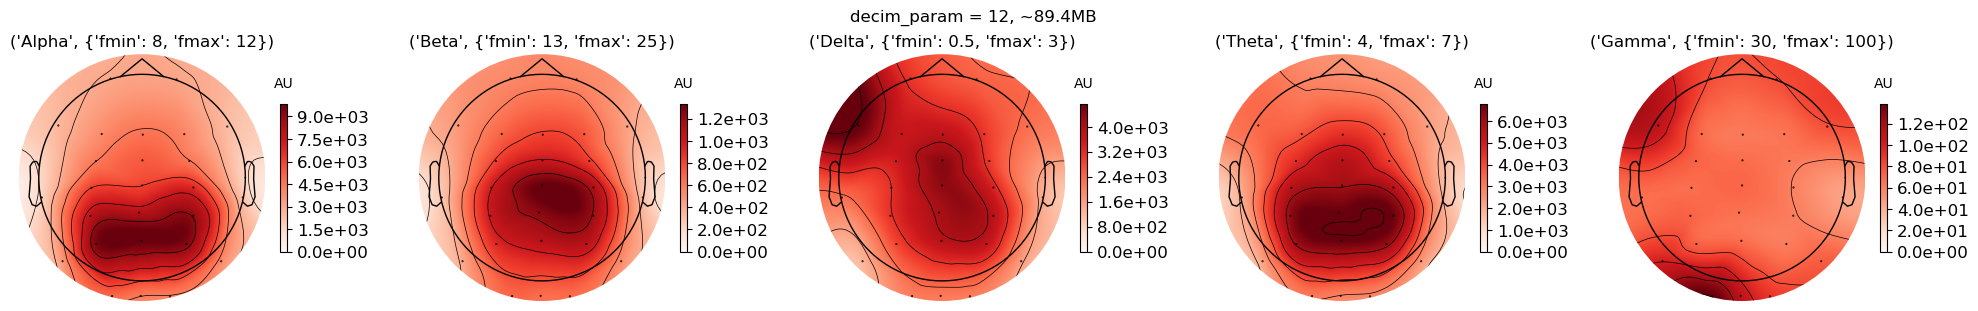

In [27]:
for ax, (decim_param, TFR_object), file_size in zip(axes.ravel(), TFR_objects.items(), file_sizes): 
    fig, axes = plt.subplots(1, 5, figsize=(20, 3), layout="constrained")
    topomap_kw = dict(
        ch_type="eeg", tmin=1, tmax=2, show=False
    )
    plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25), Delta=dict(fmin=0.5, fmax=3), Theta=dict(fmin=4, fmax=7), Gamma=dict(fmin=30, fmax=100))
    for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
        TFR_object.average().plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
        ax.set_title((title, fmin_fmax))
    fig.suptitle(f'{decim_param}, {file_size}')

In [28]:
# print overview of decimate parameter, TFR object shape, and corresponding file size
print('decimate parameter, shape of EpochsTFR object = [n_epochs, n_channels, n_freqs, n_times], and file size of corresponding object')
for (decim_param, TFR_object), file_size in zip(TFR_objects.items(), file_sizes):
    print(f'{decim_param}, shape = {TFR_object.data.shape}, {file_size =}')

decimate parameter, shape of EpochsTFR object = [n_epochs, n_channels, n_freqs, n_times], and file size of corresponding object
decim_param = 1, shape = (12, 26, 90, 5000), file_size ='~1.05GB'
decim_param = 2, shape = (12, 26, 90, 2500), file_size ='~535.6MB'
decim_param = 3, shape = (12, 26, 90, 1667), file_size ='~357.2MB'
decim_param = 4, shape = (12, 26, 90, 1250), file_size ='~267.8MB'
decim_param = 6, shape = (12, 26, 90, 834), file_size ='~178.7MB'
decim_param = 8, shape = (12, 26, 90, 625), file_size ='~133.9MB'
decim_param = 10, shape = (12, 26, 90, 500), file_size ='~107.2MB'
decim_param = 12, shape = (12, 26, 90, 417), file_size ='~89.4MB'


Next, checking for TFR calculated using Morlet wave convolution

In [29]:
# Create TFR objects with different values of 'decimate'
decim_params = [1, 2, 3, 4, 6, 8, 10, 12]
TFR_objects = {}

for decim_param in decim_params:
    TFR_object = tfr_morlet(
        epochs,
        freqs=freqs,
        n_cycles=n_cycles,
        use_fft=True,
        return_itc=False,
        average=False,
        decim=decim_param, # decim reduces sampling rate of the tf decomposition by the defined factor
        n_jobs=-1)
    TFR_objects[f'{decim_param = }'] = TFR_object
    
print(TFR_objects)

{'decim_param = 1': <EpochsTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~1.05 GB>, 'decim_param = 2': <EpochsTFR | time : [0.000000, 9.996000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~535.6 MB>, 'decim_param = 3': <EpochsTFR | time : [0.000000, 9.996000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~357.2 MB>, 'decim_param = 4': <EpochsTFR | time : [0.000000, 9.992000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~267.8 MB>, 'decim_param = 6': <EpochsTFR | time : [0.000000, 9.996000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~178.7 MB>, 'decim_param = 8': <EpochsTFR | time : [0.000000, 9.984000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~133.9 MB>, 'decim_param = 10': <EpochsTFR | time : [0.000000, 9.980000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~107.2 MB>, 'decim_param = 12': <EpochsTFR | time : [0.000000, 9.984000], freq : [1.000000, 90

In [30]:
# extract estimated file size
file_sizes = []
for key in TFR_objects:
    file_size = str(TFR_objects[key]).split(',')[6].replace(' ', '').replace('>', '')
    file_sizes.append(file_size)
print(file_sizes)

['~1.05GB', '~535.6MB', '~357.2MB', '~267.8MB', '~178.7MB', '~133.9MB', '~107.2MB', '~89.4MB']


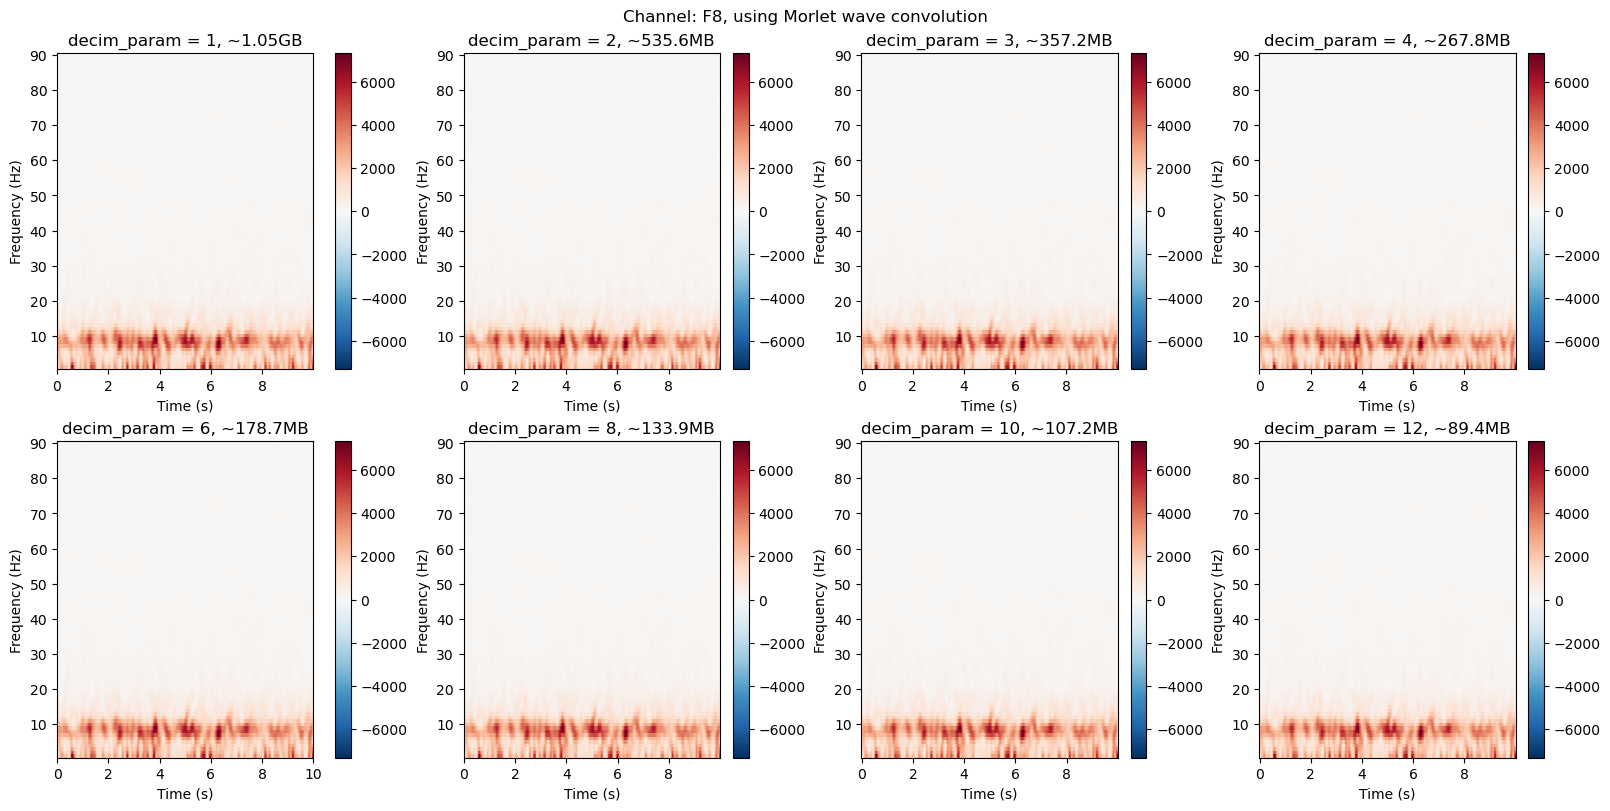

In [31]:
# plot all TFR_objects to visualize effect of 'decimate' parameter
fig, axes = plt.subplots(2, 4, figsize=(16, 8), layout='constrained')

for ax, (decim_param, TFR_object), file_size in zip(axes.ravel(), TFR_objects.items(), file_sizes):
    TFR_object.average().plot([6], axes=ax, show=False) # Have to average over epochs and select only 1 channel, in order to plot
    ax.set_title(f'{decim_param}, {file_size}')
fig.suptitle(f'Channel: {ch_names[6]}, using Morlet wave convolution')
plt.show()
    

### Checking effect of less frequencies and 'decimate' parameter on TFR object file size

In [32]:
# define frequencies of interest
freqs_1 = np.arange(1, 91, 1, dtype=int)
freqs_2 = np.arange(1, 91, 2, dtype=int)
freqs_3 = np.arange(1, 91, 4, dtype=int)
freqs = [freqs_1, freqs_2, freqs_3]

# Create TFR objects with different values of 'decimate' and different frequency resolution
decim_params = [1, 2, 4, 8]
TFR_objects = {}

for freq in freqs:
    for decim_param in decim_params:
        n_cycles = freq / 2.0 # different number of cycles per frequency
        TFR_object = tfr_multitaper(
            epochs,
            freqs=freq,
            n_cycles=n_cycles,
            time_bandwidth=4, # just random for now
            use_fft=True,
            return_itc=False,
            average=False,
            decim=decim_param, # decim reduces sampling rate of the tf decomposition by the defined factor
            n_jobs=-1)
        TFR_objects[f'{freq}{decim_param = }'] = TFR_object
    
print(TFR_objects)

{'[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24\n 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48\n 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72\n 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]decim_param = 1': <EpochsTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~1.05 GB>, '[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24\n 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48\n 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72\n 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]decim_param = 2': <EpochsTFR | time : [0.000000, 9.996000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~535.6 MB>, '[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24\n 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48\n 49 50 51 52 53 54 55 56 57 58 59 6

In [33]:
# extract estimated file size
file_sizes = []
for key in TFR_objects:
    file_size = str(TFR_objects[key]).split(',')[6].replace(' ', '').replace('>', '')
    file_sizes.append(file_size)
print(file_sizes)

['~1.05GB', '~535.6MB', '~267.8MB', '~133.9MB', '~535.6MB', '~267.8MB', '~133.9MB', '~67.0MB', '~273.8MB', '~136.9MB', '~68.5MB', '~34.3MB']


In [34]:
print('shape = [n_epochs, n_channels, n_freqs, n_times]')
for (decim_param, TFR_object), file_size in zip(TFR_objects.items(), file_sizes):
    print(f'shape = {TFR_object.data.shape}, {file_size = }')

shape = [n_epochs, n_channels, n_freqs, n_times]
shape = (12, 26, 90, 5000), file_size = '~1.05GB'
shape = (12, 26, 90, 2500), file_size = '~535.6MB'
shape = (12, 26, 90, 1250), file_size = '~267.8MB'
shape = (12, 26, 90, 625), file_size = '~133.9MB'
shape = (12, 26, 45, 5000), file_size = '~535.6MB'
shape = (12, 26, 45, 2500), file_size = '~267.8MB'
shape = (12, 26, 45, 1250), file_size = '~133.9MB'
shape = (12, 26, 45, 625), file_size = '~67.0MB'
shape = (12, 26, 23, 5000), file_size = '~273.8MB'
shape = (12, 26, 23, 2500), file_size = '~136.9MB'
shape = (12, 26, 23, 1250), file_size = '~68.5MB'
shape = (12, 26, 23, 625), file_size = '~34.3MB'


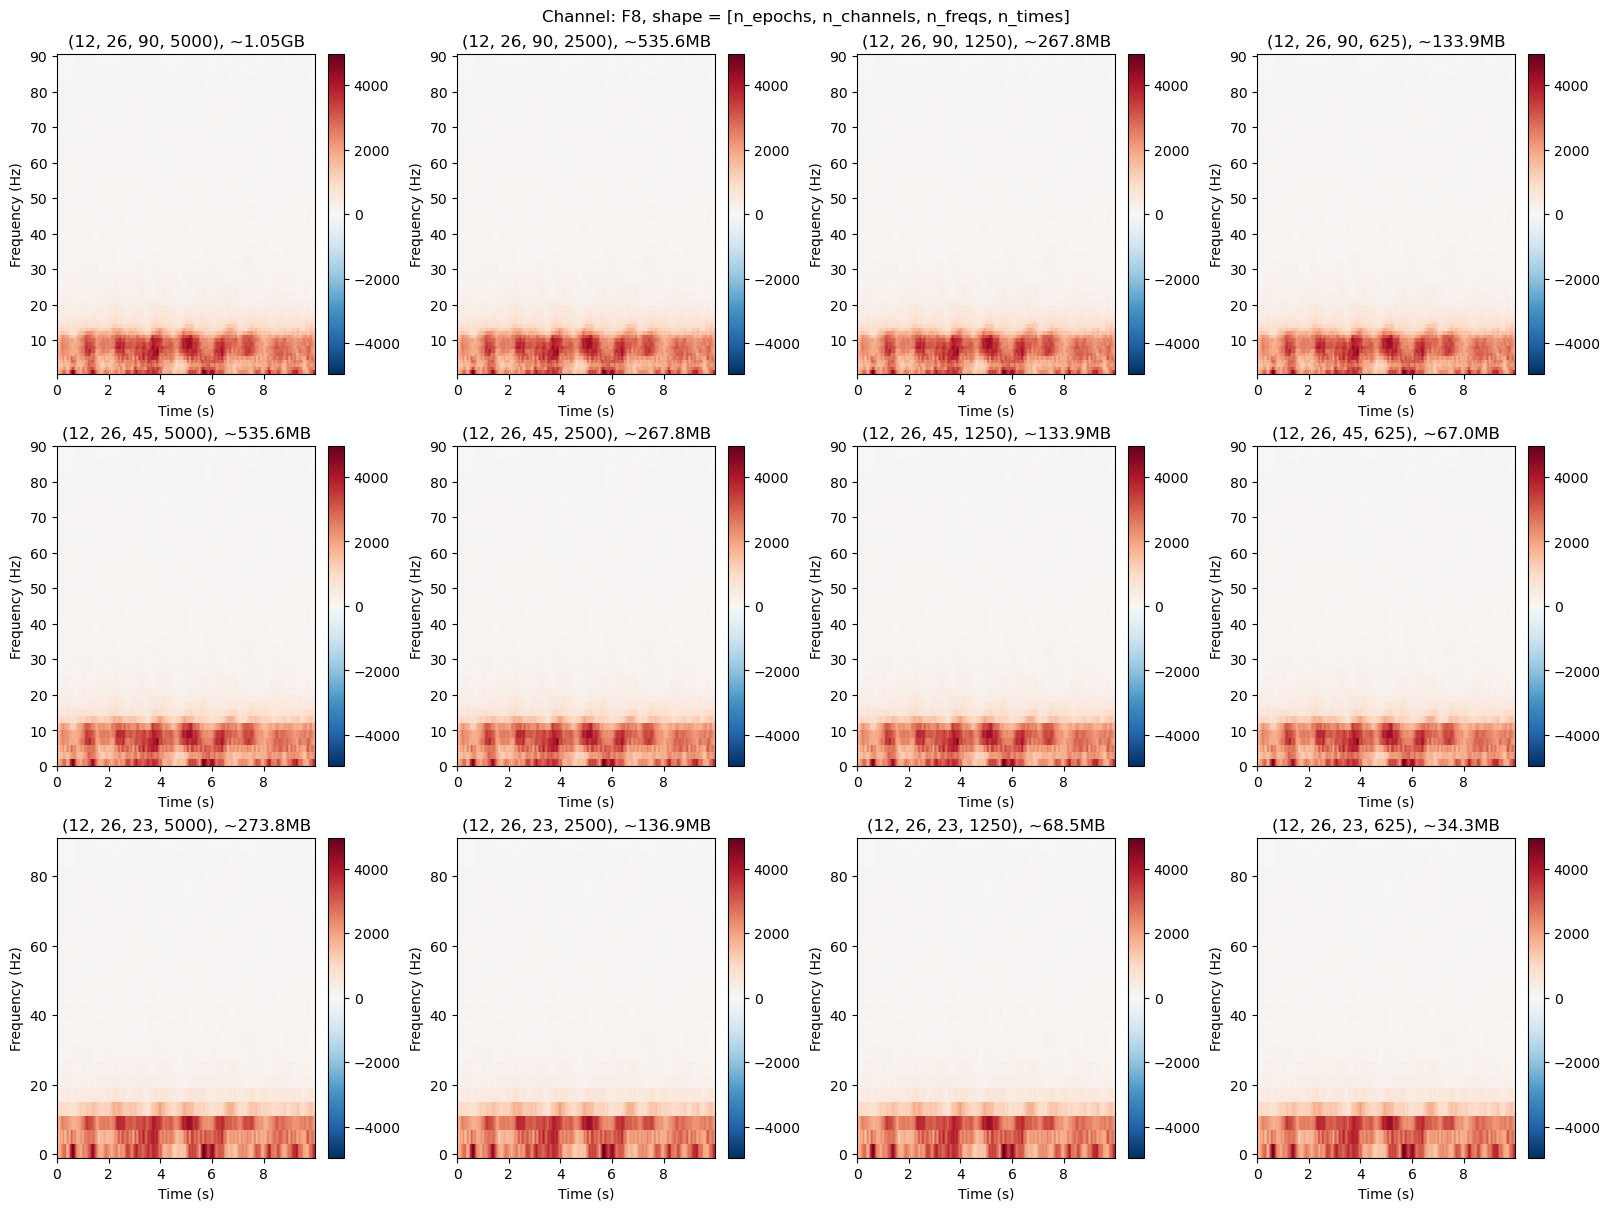

In [35]:
# plot all TFR_objects to visualize effect of 'decimate' parameter
fig, axes = plt.subplots(3, 4, figsize=(16, 12), layout='constrained')

for ax, TFR_object, file_size in zip(axes.ravel(), TFR_objects.values(), file_sizes):
    TFR_object.average().plot([6], axes=ax, show=False) # Have to average over epochs and select only 1 channel, in order to plot
    ax.set_title(f'{TFR_object.data.shape}, {file_size}')
fig.suptitle(f'Channel: {ch_names[6]}, shape = [n_epochs, n_channels, n_freqs, n_times]')
plt.show()
    

In [65]:
a = np.logspace(*np.log10([0.5, 90]), num=90)
print(a)

[ 0.5         0.53004183  0.56188868  0.59564901  0.63143779  0.66937688
  0.70959549  0.75223059  0.79742735  0.84533971  0.89613081  0.94997363
  1.00705152  1.06755886  1.13170171  1.19969849  1.27178077  1.34819401
  1.42919844  1.51506991  1.60610086  1.70260128  1.80489979  1.91334478
  2.02830554  2.15017356  2.27936386  2.41631638  2.56149751  2.71540166
  2.87855293  3.05150693  3.23485263  3.42921442  3.63525417  3.85367355
  4.08521636  4.33067111  4.59087369  4.86671018  5.15911994  5.46909875
  5.79770222  6.14604939  6.51532654  6.9067912   7.3217765   7.76169563
  8.22804671  8.72241788  9.24649267  9.80205579 10.39099918 11.01532845
 11.6771697  12.3787768  13.12253902 13.91098919 14.74681234 15.6328548
 16.57213394 17.56784841 18.62338904 19.74235042 20.9285431  22.18600657
 23.51902305 24.93213204 26.43014579 28.01816569 29.70159964 31.48618047
 33.37798544 35.38345697 37.50942458 39.7631281  42.15224238 44.68490339
 47.36973595 50.21588307 53.23303713 56.43147285 59.

In [66]:
# array for frequencies to include in TFR object
b = np.logspace(*np.log10([0.5, 90]), num=30)
print(b)

[ 0.5         0.59805073  0.71532934  0.85560646  1.02339213  1.22408082
  1.46412484  1.75124185  2.09466291  2.50542935  2.99674769  3.58441426
  4.28732309  5.12807338  6.13369601  7.3365227   8.77522545 10.4960599
 12.55435248 15.01627922 17.96099338 21.48317025 25.69605112 30.73508404
 36.76227863 43.97141483 52.5942731  62.9080864  75.24445346 90.        ]


In [67]:
# 5 frequencies per frequency band
c = np.array([0.5, 1.125, 1.75, 2.375, 3, # delta
              4, 4.75, 5.5, 6.25, 7, # theta
              8, 9, 10, 11, 12, # alpha
              13, 17.25, 21.5, 25.75, 30, # beta
              42, 54, 66, 78, 90 # gamma
              ])
print(c)

[ 0.5    1.125  1.75   2.375  3.     4.     4.75   5.5    6.25   7.
  8.     9.    10.    11.    12.    13.    17.25  21.5   25.75  30.
 42.    54.    66.    78.    90.   ]


In [81]:
# define frequencies of interest
freqs = [a, b, c]

TFR_objects = []

for freq in freqs:
        print(freq.size)
        n_cycles = freq / 2.0 # different number of cycles per frequency
        TFR_object = tfr_multitaper(
            epochs,
            freqs=freq,
            n_cycles=n_cycles,
            time_bandwidth=4, # just random for now
            use_fft=True,
            return_itc=False,
            average=False,
            decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
            n_jobs=-1)
        TFR_object.apply_baseline((0, 0.5), mode='mean')
        TFR_objects.append(TFR_object)
    
print(TFR_objects)

90
30
25
[<EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~1.05 GB>, <EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~357.1 MB>, <EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~297.6 MB>]


In [82]:
# extract estimated file size
file_sizes = []
for TFR_object in TFR_objects:
    file_size = str(TFR_object).split(',')[6].replace(' ', '').replace('>', '')
    file_sizes.append(file_size)
print(file_sizes)

['~1.05GB', '~357.1MB', '~297.6MB']


In [83]:
print('shape = [n_epochs, n_channels, n_freqs, n_times]')
for TFR_object, file_size in zip(TFR_objects, file_sizes):
    print(f'shape = {TFR_object.data.shape}, {file_size = }')

shape = [n_epochs, n_channels, n_freqs, n_times]
shape = (12, 26, 90, 5000), file_size = '~1.05GB'
shape = (12, 26, 30, 5000), file_size = '~357.1MB'
shape = (12, 26, 25, 5000), file_size = '~297.6MB'


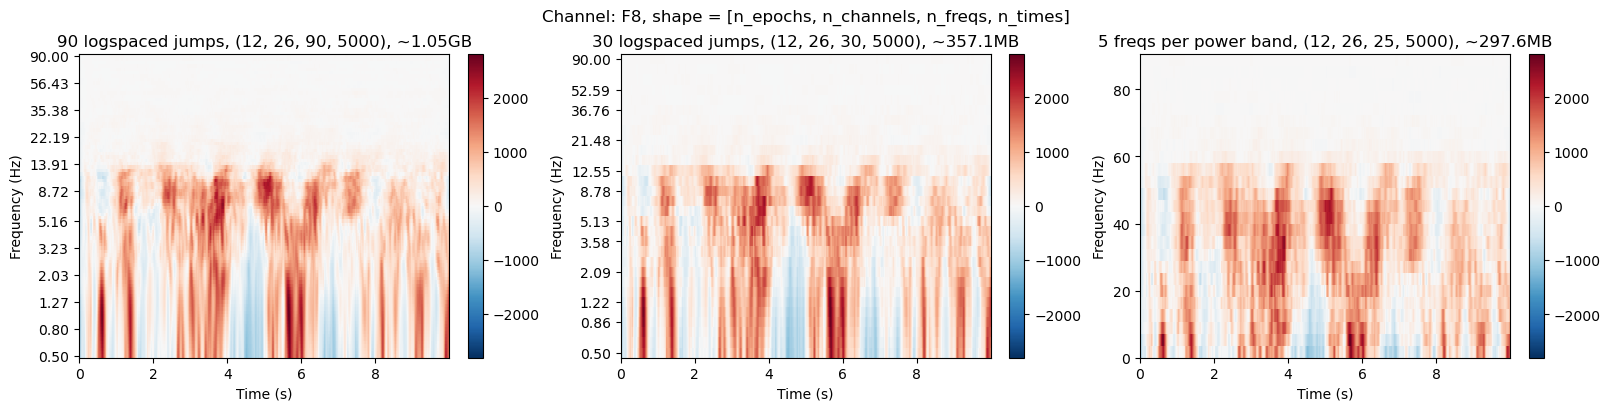

In [84]:
# plot all TFR_objects to visualize effect of 'decimate' parameter
fig, axes = plt.subplots(1, 3, figsize=(16, 4), layout='constrained')

for ax, TFR_object, file_size in zip(axes.ravel(), TFR_objects, file_sizes):
    TFR_object.average().plot([6], axes=ax, show=False) # Have to average over epochs and select only 1 channel, in order to plot
axes[0].set_title(f'90 logspaced jumps, {TFR_objects[0].data.shape}, {file_sizes[0]}')
axes[1].set_title(f'30 logspaced jumps, {TFR_objects[1].data.shape}, {file_sizes[1]}')
axes[2].set_title(f'5 freqs per power band, {TFR_objects[2].data.shape}, {file_sizes[2]}')
fig.suptitle(f'Channel: {ch_names[6]}, shape = [n_epochs, n_channels, n_freqs, n_times]')
plt.show()
    

### Checking effect of less frequencies & decimate parameter on file size and on STD of power per freq per channel

In [80]:
freq_1 = np.logspace(*np.log10([0.5, 90]), num=90)
freq_2 = np.logspace(*np.log10([0.5, 90]), num=30)
freq_3 = np.array([0.5, 1.125, 1.75, 2.375, 3, # delta
              4, 4.75, 5.5, 6.25, 7, # theta
              8, 9, 10, 11, 12, # alpha
              13, 17.25, 21.5, 25.75, 30, # beta
              42, 54, 66, 78, 90 # gamma
              ])


In [86]:
# define frequencies of interest
freqs = [freq_1, freq_2, freq_3]

# Create TFR objects with different values of 'decimate' and different frequency resolution
decim_params = [1, 2, 4, 8]
TFR_objects = {}

for freq in freqs:
    for decim_param in decim_params:
        n_cycles = freq / 2.0 # different number of cycles per frequency
        TFR_object = tfr_multitaper(
            epochs,
            freqs=freq,
            n_cycles=n_cycles,
            time_bandwidth=4, # just random for now
            use_fft=True,
            return_itc=False,
            average=False,
            decim=decim_param, # decim reduces sampling rate of the tf decomposition by the defined factor
            n_jobs=-1)
        TFR_object.apply_baseline((0, 0.5), mode='mean')
        TFR_objects[f'{freq}{decim_param = }'] = TFR_object
    
print(TFR_objects)

{'[ 0.5         0.53004183  0.56188868  0.59564901  0.63143779  0.66937688\n  0.70959549  0.75223059  0.79742735  0.84533971  0.89613081  0.94997363\n  1.00705152  1.06755886  1.13170171  1.19969849  1.27178077  1.34819401\n  1.42919844  1.51506991  1.60610086  1.70260128  1.80489979  1.91334478\n  2.02830554  2.15017356  2.27936386  2.41631638  2.56149751  2.71540166\n  2.87855293  3.05150693  3.23485263  3.42921442  3.63525417  3.85367355\n  4.08521636  4.33067111  4.59087369  4.86671018  5.15911994  5.46909875\n  5.79770222  6.14604939  6.51532654  6.9067912   7.3217765   7.76169563\n  8.22804671  8.72241788  9.24649267  9.80205579 10.39099918 11.01532845\n 11.6771697  12.3787768  13.12253902 13.91098919 14.74681234 15.6328548\n 16.57213394 17.56784841 18.62338904 19.74235042 20.9285431  22.18600657\n 23.51902305 24.93213204 26.43014579 28.01816569 29.70159964 31.48618047\n 33.37798544 35.38345697 37.50942458 39.7631281  42.15224238 44.68490339\n 47.36973595 50.21588307 53.23303713 

In [87]:
# extract estimated file size
file_sizes = []
for key in TFR_objects:
    file_size = str(TFR_objects[key]).split(',')[6].replace(' ', '').replace('>', '')
    file_sizes.append(file_size)
print(file_sizes)

['~1.05GB', '~535.6MB', '~267.8MB', '~133.9MB', '~357.1MB', '~178.6MB', '~89.3MB', '~44.7MB', '~297.6MB', '~148.8MB', '~74.4MB', '~37.2MB']


In [88]:
print('shape = [n_epochs, n_channels, n_freqs, n_times]')
for (decim_param, TFR_object), file_size in zip(TFR_objects.items(), file_sizes):
    print(f'shape = {TFR_object.data.shape}, {file_size = }')

shape = [n_epochs, n_channels, n_freqs, n_times]
shape = (12, 26, 90, 5000), file_size = '~1.05GB'
shape = (12, 26, 90, 2500), file_size = '~535.6MB'
shape = (12, 26, 90, 1250), file_size = '~267.8MB'
shape = (12, 26, 90, 625), file_size = '~133.9MB'
shape = (12, 26, 30, 5000), file_size = '~357.1MB'
shape = (12, 26, 30, 2500), file_size = '~178.6MB'
shape = (12, 26, 30, 1250), file_size = '~89.3MB'
shape = (12, 26, 30, 625), file_size = '~44.7MB'
shape = (12, 26, 25, 5000), file_size = '~297.6MB'
shape = (12, 26, 25, 2500), file_size = '~148.8MB'
shape = (12, 26, 25, 1250), file_size = '~74.4MB'
shape = (12, 26, 25, 625), file_size = '~37.2MB'


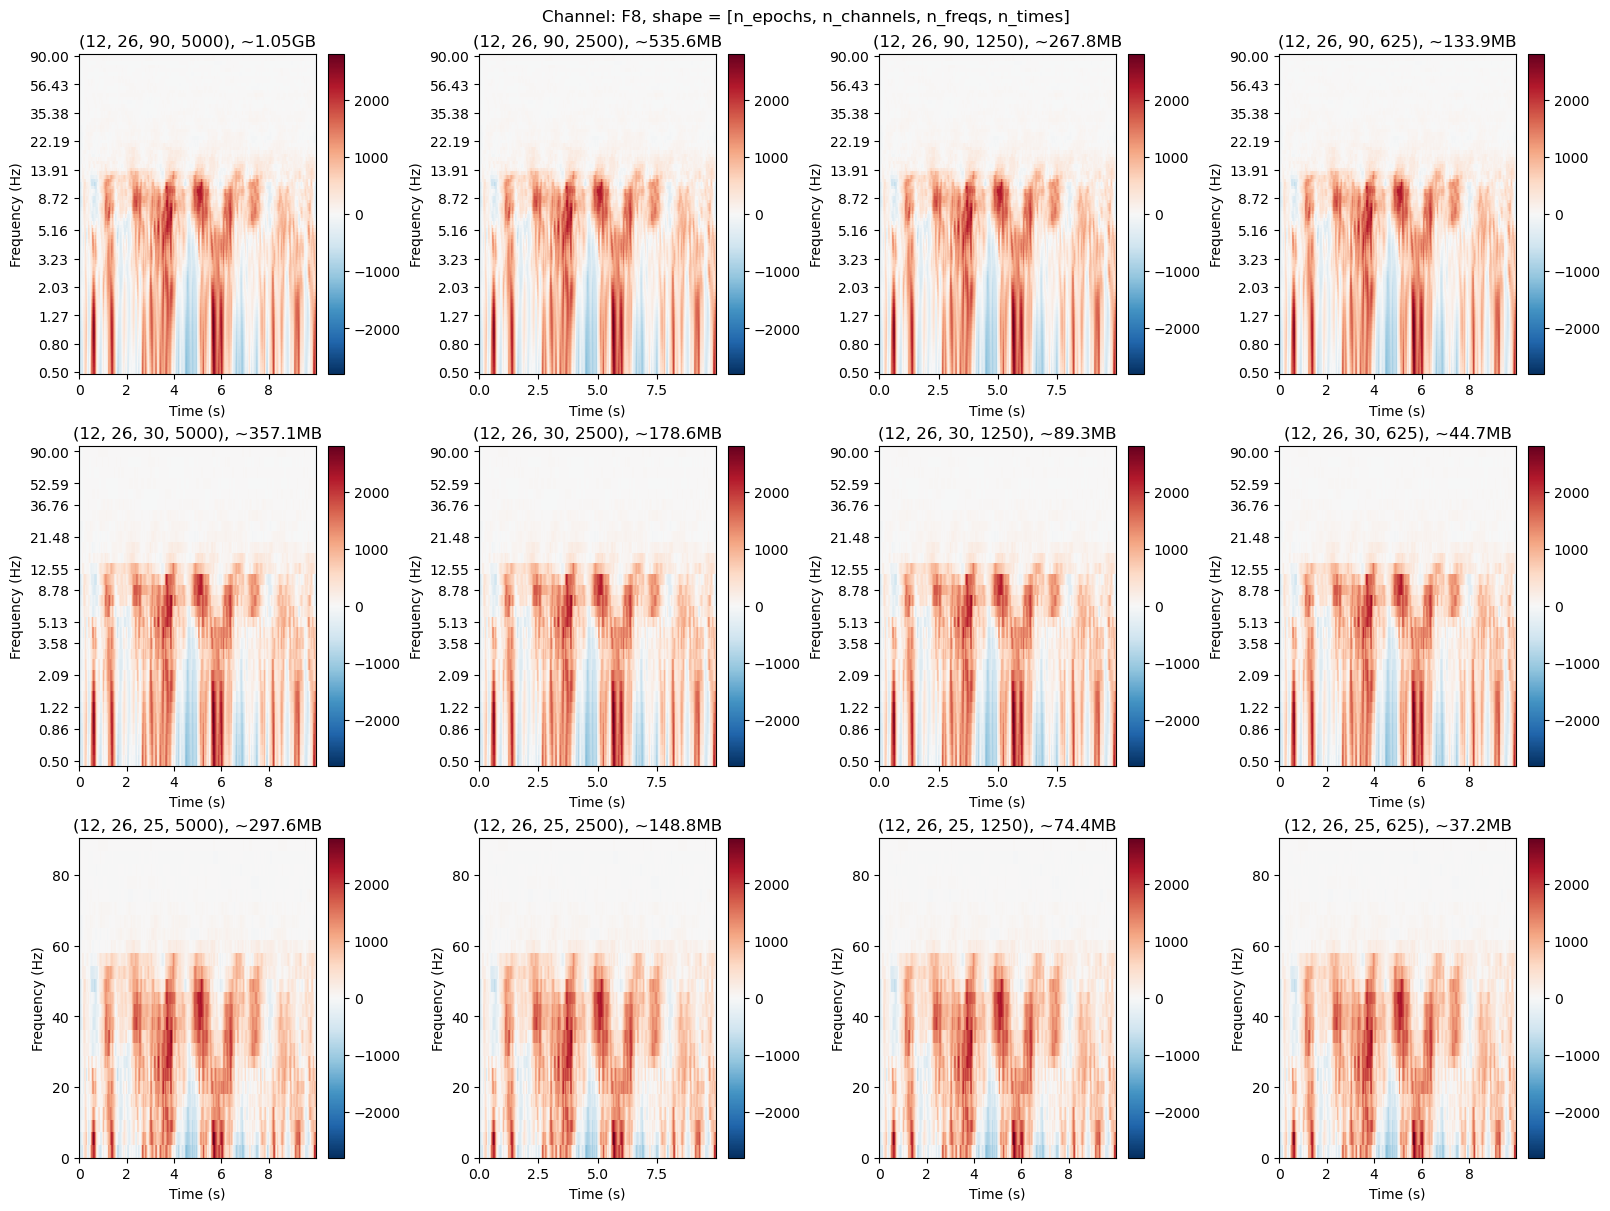

In [89]:
# plot all TFR_objects to visualize effect of 'decimate' parameter
fig, axes = plt.subplots(3, 4, figsize=(16, 12), layout='constrained')

for ax, TFR_object, file_size in zip(axes.ravel(), TFR_objects.values(), file_sizes):
    TFR_object.average().plot([6], axes=ax, show=False) # Have to average over epochs and select only 1 channel, in order to plot
    ax.set_title(f'{TFR_object.data.shape}, {file_size}')
fig.suptitle(f'Channel: {ch_names[6]}, shape = [n_epochs, n_channels, n_freqs, n_times]')
plt.show()
    

In [109]:
stdev_array = np.zeros(shape=(len(TFR_objects), 26, 1))
print(stdev_array.shape)
TFR_object = TFR_objects[]

(12, 26, 1)


KeyError: 0

In [105]:
stdev_array = np.zeros(shape=(len(TFR_objects), 26, 1))
for TFR_object in TFR_objects.values():
    #print(TFR_object.average().data.shape)
    stdev = np.std(TFR_object.average().data, axis=2)
    stdev_array = np.append([stdev_array], stdev, axis=1)
    #print(stdev.shape)

print(stdev_array.shape)
print(stdev[6][1])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 2 dimension(s)